## Bayes

In [42]:
from scipy import io
from scipy.stats import norm
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import  KMeans

In [43]:
# 数据加载与解析
mask = io.loadmat('mask.mat')['Mask']                              # 数据为一个字典，根据key提取数据
sample = io.loadmat('array_sample.mat')['array_sample']
src_image = Image.open('309.bmp')
RGB_img = np.array(src_image)
Gray_img = np.array(src_image.convert('L'))

# 根据Mask，获取ROI区域
Gray_ROI = (Gray_img * mask)/255
RGB_mask = np.array([mask, mask, mask]).transpose(1, 2, 0)
RGB_ROI = (RGB_img * RGB_mask)/255

# 根据标签拆分数据
gray1, gray2, RGB1, RGB2 = [], [], [], []

for i in range(len(sample)):
    if(sample[i][4]) == 1.:                                           # 数据第5位为标签
        gray1.append(sample[i][0])
        RGB1.append(sample[i][1:4])
    else:
        gray2.append(sample[i][0])
        RGB2.append(sample[i][1:4])

RGB1 = np.array(RGB1)
RGB2 = np.array(RGB2)
Gray_ROI = Gray_ROI[20:180,50:200]
RGB_ROI = RGB_ROI[20:180,50:200]

In [44]:
Gray_ROI_sample = Gray_ROI.reshape(-1)
Gray_ROI_sample = Gray_ROI_sample[Gray_ROI_sample != 0]

In [46]:
len(Gray_ROI_sample)

7364

In [48]:
len(sample)

7696

In [3]:
P_pre1 = len(gray1)/len(sample)
P_pre2 = 1-P_pre1
P_pre1,P_pre2

(0.683991683991684, 0.316008316008316)

In [4]:
# 一维时，贝叶斯
# ------------------------------------------------------------------------------------#
# 数据为一维时(灰度图像)，用最大似然估计两个类别条件概率pdf的参数——标准差与均值
gray1_m = np.mean(gray1)
gray1_s = np.std(gray1)
gray2_m = np.mean(gray2)
gray2_s = np.std(gray2)
# print(gray1_s, gray2_s)

# 绘制最大似然估计出的类条件pdf
x = np.arange(0, 1, 1/1000)
gray1_pdf = norm.pdf(x, gray1_m, gray1_s)
gray2_pdf = norm.pdf(x, gray2_m, gray2_s)

Text(0, 0.5, '$f(x)$')

<Figure size 432x288 with 0 Axes>

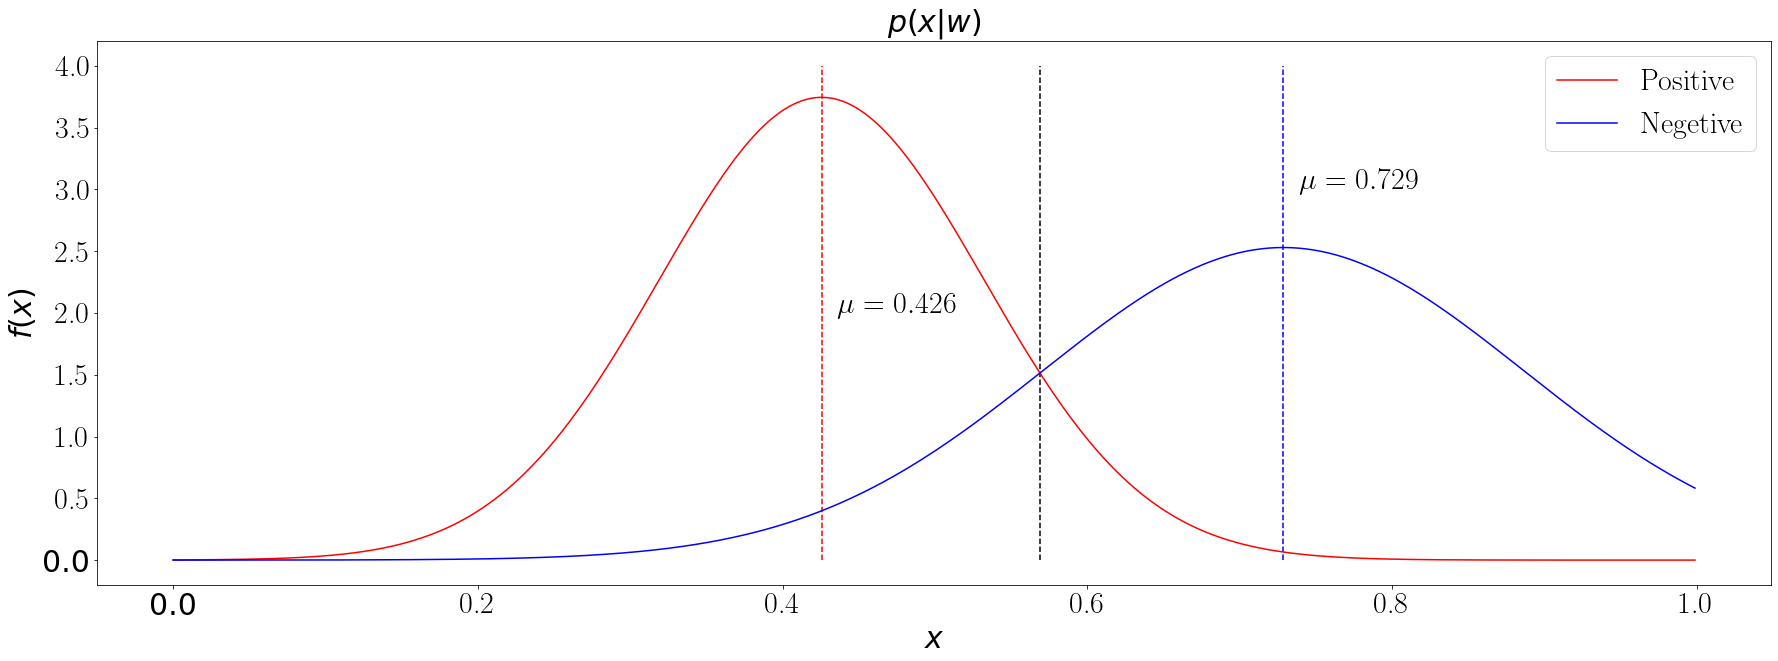

In [5]:
'''
使用了latex渲染文本,运行时电脑需有tex环境
'''

plt.figure(0)
plt.figure(figsize=(30, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('$p(x|w)$', fontsize=30)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

gray_dist = np.abs(gray1_pdf[200:] - gray2_pdf[200:])
gray_face = np.min(gray_dist)
gray_face_loc = np.where(gray_dist == gray_face)
gray_face_loc = gray_face_loc[0] + 200
# ax.plot(gray_face_loc/1000, gray1_pdf[gray_face_loc], 'ko', markersize=10,label = 'Decision Surface')
plt.vlines(gray_face_loc/1000, 0, 4, colors = "k", linestyles = "dashed")
# plt.text(gray_face_loc/1000 + 0.01 ,gray1_pdf[gray_face_loc],'$d=%.3f$'%(gray_face_loc/1000 + 0.01), fontsize=30)

plt.vlines(gray1_m, 0, 4, colors = "r", linestyles = "dashed")
plt.text(gray1_m + 0.01 ,2,'$\mu=%.3f$'%gray1_m, fontsize=30)
plt.vlines(gray2_m, 0, 4, colors = "b", linestyles = "dashed")
plt.text(gray2_m + 0.01,3,'$\mu=%.3f$'%gray2_m, fontsize=30)
ax.plot(x, gray1_pdf, 'r', label = 'Positive')
ax.plot(x, gray2_pdf, 'b', label = 'Negetive')
plt.tick_params(labelsize=30)
plt.legend(fontsize=30)
ax.set_xlabel('$x$', fontsize=30)
ax.set_ylabel('$f(x)$', fontsize=30)

In [6]:
gray1_pdf[gray_face_loc]

array([1.51438952])

In [7]:
P_pre1*gray1_pdf[gray_face_loc]

array([1.03582984])

Text(0, 0.5, '$f(x)$')

<Figure size 432x288 with 0 Axes>

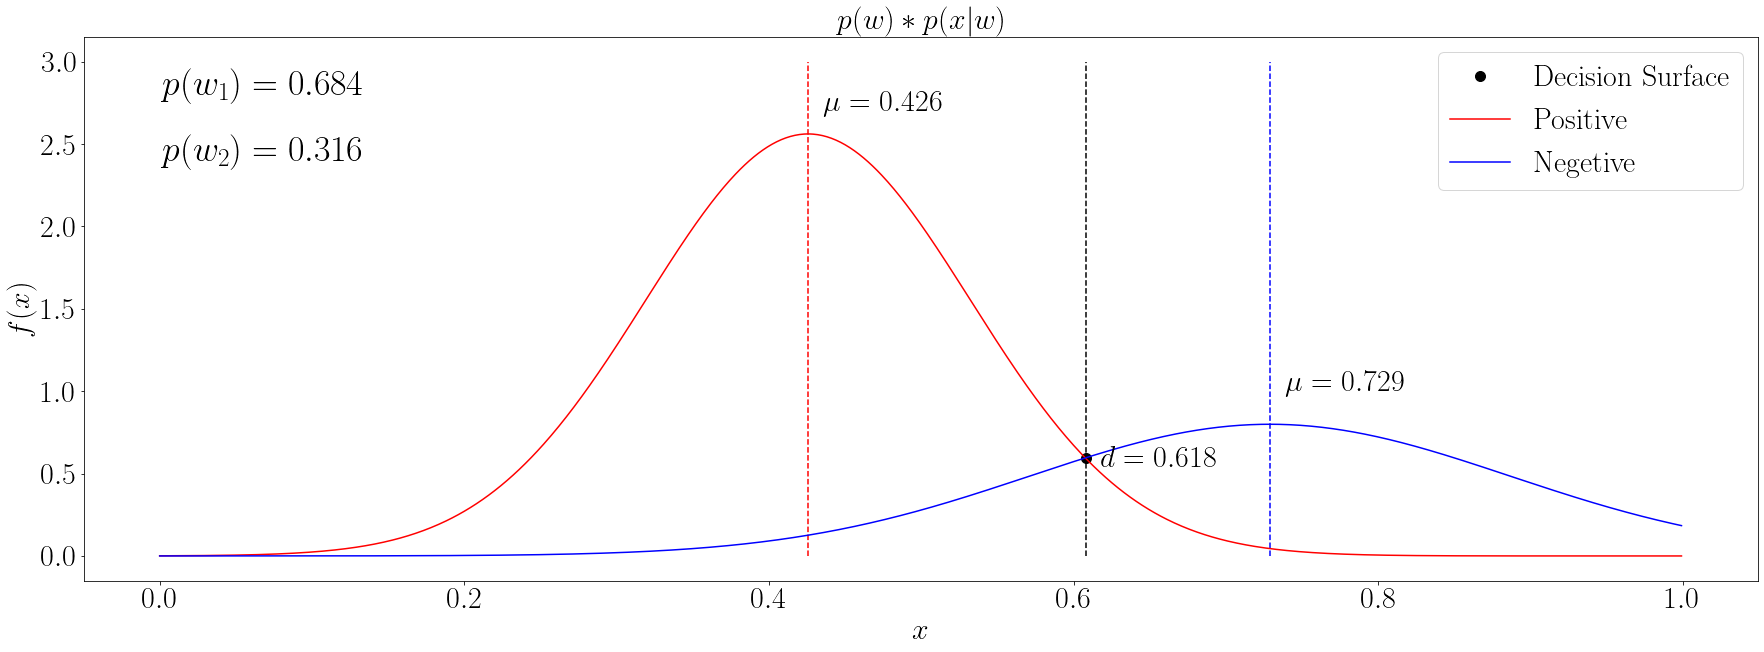

In [8]:
plt.figure(1)
plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 1, 1)
ax1.set_title('$p(w)*p(x|w)$', fontsize=30)

gray_dist = np.abs(P_pre1*gray1_pdf[200:] - P_pre2*gray2_pdf[200:])
gray_face = np.min(gray_dist)
gray_face_loc = np.where(gray_dist == gray_face)
gray_face_loc = gray_face_loc[0] + 200
ax1.plot(gray_face_loc/1000, P_pre1*gray1_pdf[gray_face_loc], 'ko', markersize=10,label = 'Decision Surface')

plt.vlines(gray_face_loc/1000, 0, 3, colors = "k", linestyles = "dashed")
plt.text(gray_face_loc/1000 + 0.01 ,P_pre1*gray1_pdf[gray_face_loc]-0.05,'$d=%.3f$'%(gray_face_loc/1000 + 0.01), fontsize=30)

plt.vlines(gray1_m, 0, 3, colors = "r", linestyles = "dashed")
plt.text(gray1_m + 0.01,3-0.3,'$\mu=%.3f$'%gray1_m, fontsize=30)
plt.vlines(gray2_m, 0, 3, colors = "b", linestyles = "dashed")
plt.text(gray2_m + 0.01,1,'$\mu=%.3f$'%gray2_m, fontsize=30)
plt.text(0,2.8,'$p(w_1)=%.3f$'%P_pre1, fontsize=36)
plt.text(0,2.4,'$p(w_2)=%.3f$'%P_pre2, fontsize=36)
ax1.plot(x, P_pre1*gray1_pdf, 'r', label = 'Positive')
ax1.plot(x, P_pre2*gray2_pdf, 'b', label = 'Negetive')
plt.legend(fontsize=30)

plt.tick_params(labelsize=30)
ax1.set_xlabel('$x$', fontsize=30)
ax1.set_ylabel('$f(x)$', fontsize=30)

W:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

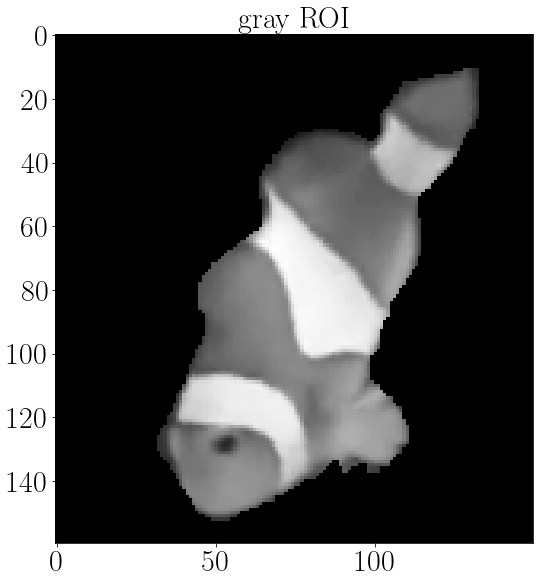

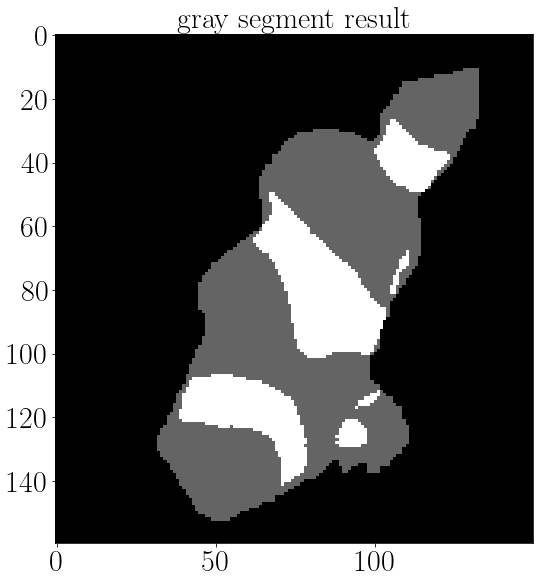

In [9]:
# 用最大后验贝叶斯对灰度图像进行分割
gray_out = np.zeros_like(Gray_ROI)
for i in range(len(Gray_ROI)):
    for j in range(len(Gray_ROI[0])):
        if Gray_ROI[i][j] == 0:
            continue
        elif P_pre1*norm.pdf(Gray_ROI[i][j], gray1_m, gray1_s) > P_pre2*norm.pdf(Gray_ROI[i][j], gray2_m, gray2_s):   # 贝叶斯公式分子比较
            gray_out[i][j] = 100
        else:
            gray_out[i][j] = 255

# plt.imshow(RGB_ROI)
plt.figure(2)
plt.figure(figsize=(10, 37.5/4))
bx = plt.subplot(1, 1, 1)
bx.set_title('gray ROI', fontsize=30)
bx.imshow(Gray_ROI, cmap='gray')
plt.tick_params(labelsize=30)


plt.figure(3)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
bx1 = plt.subplot(1, 1, 1)
bx1.set_title('gray segment result', fontsize=30)
bx1.imshow(gray_out, cmap='gray')


In [ ]:
# 三维时，贝叶斯
# ------------------------------------------------------------------------------------#
# 数据为三维时(彩色图像)，用最大似然估计两个类别条件概率pdf的参数——协方差与均值
RGB1_m = np.mean(RGB1, axis=0)
RGB2_m = np.mean(RGB2, axis=0)

cov_sum1 = np.zeros((3, 3))
cov_sum2 = np.zeros((3, 3))

for i in range(len(RGB1)):
    # print((RGB1[i]-RGB1_m).reshape(3, 1))
    cov_sum1 = cov_sum1 + np.dot((RGB1[i]-RGB1_m).reshape(3, 1), (RGB1[i]-RGB1_m).reshape(1, 3))

for i in range(len(RGB2)):
    cov_sum2 = cov_sum2 + np.dot((RGB2[i]-RGB2_m).reshape(3, 1), (RGB2[i]-RGB2_m).reshape(1, 3))

RGB1_cov = cov_sum1/(len(RGB1)-1)                      # 无偏估计除以N-1
RGB2_cov = cov_sum2/(len(RGB2)-1)

xx = np.array([x, x, x])
# print(P_pre1*multivariate_normal.pdf(RGB1, RGB1_m, RGB1_cov))

# 用最大后验贝叶斯对彩色图像进行分割
RGB_out = np.zeros_like(RGB_ROI)
for i in range(len(RGB_ROI)):
    for j in range(len(RGB_ROI[0])):
        if np.sum(RGB_ROI[i][j]) == 0:
            continue
        elif P_pre1*multivariate_normal.pdf(RGB_ROI[i][j], RGB1_m, RGB1_cov) > P_pre2*multivariate_normal.pdf(RGB_ROI[i][j], RGB2_m, RGB2_cov): # 贝叶斯公式分子比较
            RGB_out[i][j] = np.array([255, 128, 64]) / 255
        else:
            RGB_out[i][j] = np.array([255, 255, 255]) / 255
# print(RGB_ROI.shape)

# 显示RGB ROI，与彩色分割结果
plt.figure(3)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx = plt.subplot(1, 1, 1)
cx.set_title('RGB ROI', fontsize=30)
cx.imshow(RGB_ROI)
plt.figure(4)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx1 = plt.subplot(1, 1, 1)
cx1.set_title('RGB segment result', fontsize=30)
cx1.imshow(RGB_out)
plt.show()

## mean

In [11]:
Gray_ROI_sample = Gray_ROI.reshape(-1)
Gray_ROI_sample = Gray_ROI_sample[Gray_ROI_sample != 0]
gray1, gray2 = [], []
P_pre1, P_pre2 =0, 0
for i,data in enumerate(Gray_ROI_sample):
    if data <= np.mean(Gray_ROI_sample):
        gray1.append(data)
        P_pre1 -=- 1
    else:
        gray2.append(data)
        P_pre2 -=- 1
P_pre1 = P_pre1 / len(Gray_ROI_sample)
P_pre2 = P_pre2 / len(Gray_ROI_sample)

In [12]:
P_pre1, P_pre2

(0.617055947854427, 0.38294405214557303)

In [13]:
# 一维时，贝叶斯
# ------------------------------------------------------------------------------------#
# 数据为一维时(灰度图像)，用最大似然估计两个类别条件概率pdf的参数——标准差与均值
gray1_m = np.mean(gray1)
gray1_s = np.std(gray1)
gray2_m = np.mean(gray2)
gray2_s = np.std(gray2)
# print(gray1_s, gray2_s)

# 绘制最大似然估计出的类条件pdf
x = np.arange(0, 1, 1/1000)
gray1_pdf = norm.pdf(x, gray1_m, gray1_s)
gray2_pdf = norm.pdf(x, gray2_m, gray2_s)

Text(0, 0.5, '$f(x)$')

<Figure size 432x288 with 0 Axes>

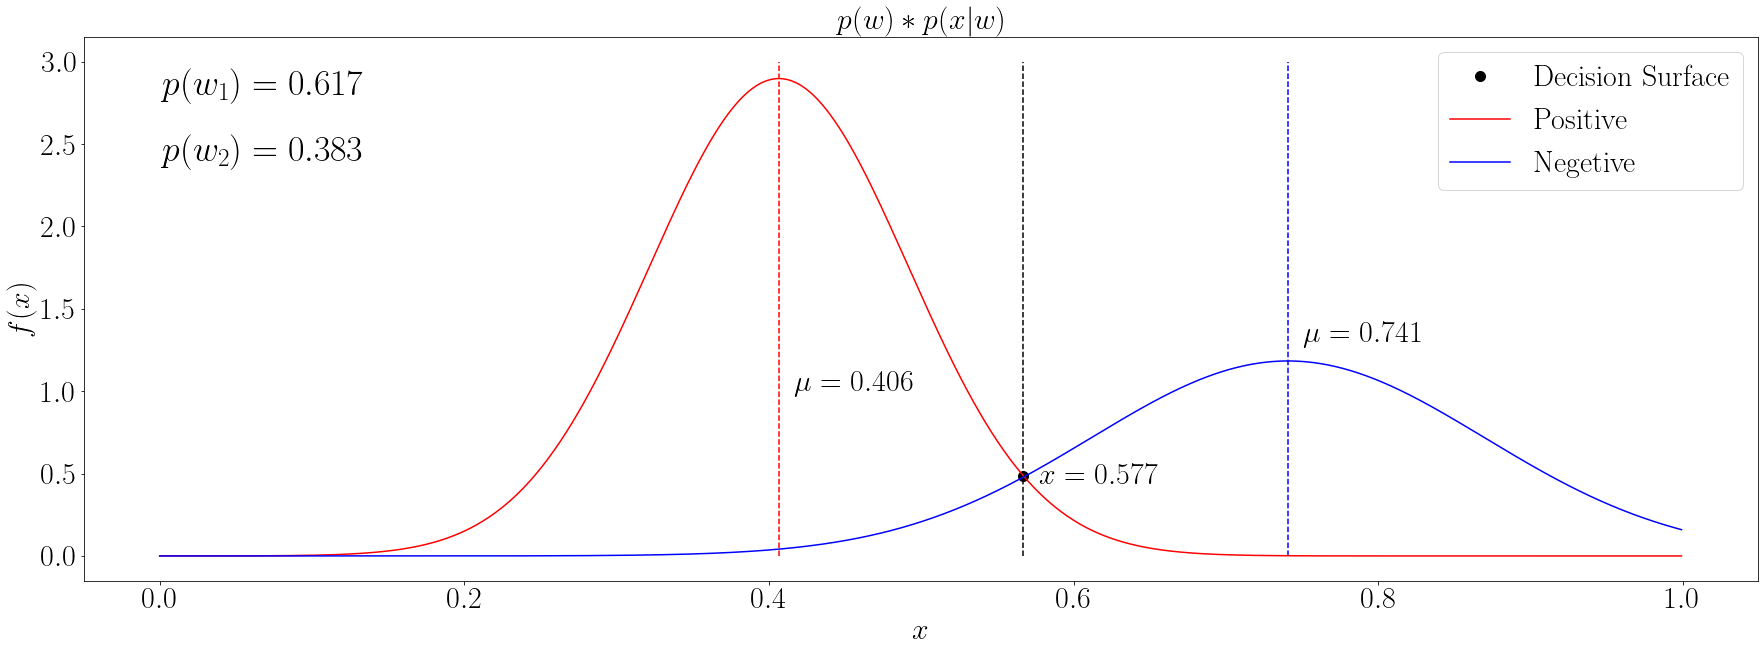

In [14]:
plt.figure(1)
plt.figure(figsize=(30, 10))
ax2= plt.subplot(1, 1, 1)
ax2.set_title('$p(w)*p(x|w)$', fontsize=30)

gray_dist = np.abs(P_pre1*gray1_pdf[200:] - P_pre2*gray2_pdf[200:])
gray_face = np.min(gray_dist)
gray_face_loc = np.where(gray_dist == gray_face)
gray_face_loc = gray_face_loc[0] + 200
ax2.plot(gray_face_loc/1000, P_pre1*gray1_pdf[gray_face_loc], 'ko', markersize=10,label = 'Decision Surface')

plt.vlines(gray_face_loc/1000, 0, 3, colors = "k", linestyles = "dashed")
plt.text(gray_face_loc/1000 + 0.01 ,P_pre1*gray1_pdf[gray_face_loc]-0.05,'$x=%.3f$'%(gray_face_loc/1000 + 0.01), fontsize=30)

plt.vlines(gray1_m, 0, 3, colors = "r", linestyles = "dashed")
plt.text(gray1_m + 0.01,1,'$\mu=%.3f$'%gray1_m, fontsize=30)
plt.vlines(gray2_m, 0, 3, colors = "b", linestyles = "dashed")
plt.text(gray2_m + 0.01,1+0.3,'$\mu=%.3f$'%gray2_m, fontsize=30)
plt.text(0,2.8,'$p(w_1)=%.3f$'%P_pre1, fontsize=36)
plt.text(0,2.4,'$p(w_2)=%.3f$'%P_pre2, fontsize=36)
ax2.plot(x, P_pre1*gray1_pdf, 'r', label = 'Positive')
ax2.plot(x, P_pre2*gray2_pdf, 'b', label = 'Negetive')
plt.legend(fontsize=30)

plt.tick_params(labelsize=30)
ax2.set_xlabel('$x$', fontsize=30)
ax2.set_ylabel('$f(x)$', fontsize=30)

W:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
W:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

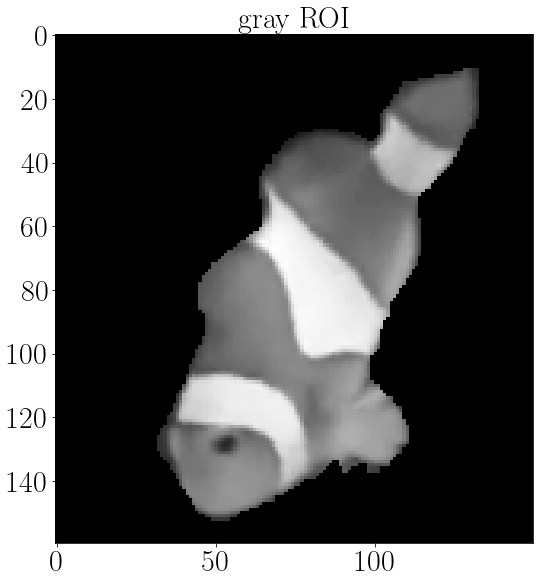

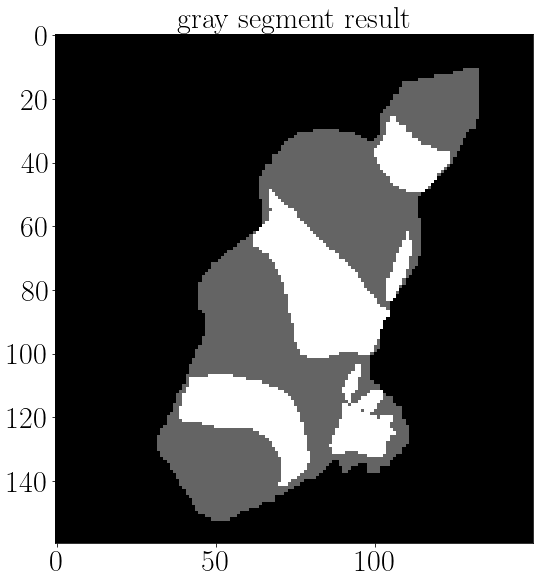

In [18]:
# 用最大后验贝叶斯对灰度图像进行分割
gray_out = np.zeros_like(Gray_ROI)
for i in range(len(Gray_ROI)):
    for j in range(len(Gray_ROI[0])):
        if Gray_ROI[i][j] == 0:
            continue
        elif P_pre1*norm.pdf(Gray_ROI[i][j], gray1_m, gray1_s) > P_pre2*norm.pdf(Gray_ROI[i][j], gray2_m, gray2_s):   # 贝叶斯公式分子比较
            gray_out[i][j] = 100
        else:
            gray_out[i][j] = 255

# plt.imshow(RGB_ROI)
plt.figure(2)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
bx = plt.subplot(1, 1, 1)
bx.set_title('gray ROI', fontsize=30)
bx.imshow(Gray_ROI, cmap='gray')
plt.figure(3)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
bx1 = plt.subplot(1, 1, 1)
bx1.set_title('gray segment result', fontsize=30)
bx1.imshow(gray_out, cmap='gray')

In [20]:
#对三个通道归一化
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
RGB_ROI_sample_ = RGB_ROI.reshape((-1,3))
RGB_ROI_sample = []
for i in range(len(RGB_ROI_sample_)):
    if np.sum(RGB_ROI_sample_[i]) != 0:
        RGB_ROI_sample.append(RGB_ROI_sample_[i])
RGB_ROI_sample = np.array(RGB_ROI_sample)
standardScaler.fit(RGB_ROI_sample)
RGB_ROI_norm_mean = np.mean(standardScaler.transform(RGB_ROI_sample),axis=1)

# for i in range(len(RGB_ROI_sample)):
#     if RGB_ROI_norm_mean[i] <= 0:
#         RGB_1.append(RGB_ROI_sample[i])
        
#     else:
#         RGB_1.append(RGB_ROI_sample[i])
RGB_1, RGB_2 = [], []
P_pre1, P_pre2 =0, 0
for i,data in enumerate(RGB_ROI_norm_mean):
    if data <= 0:
        RGB_1.append(RGB_ROI_sample[i])
        P_pre1 -=- 1
    else:
        RGB_2.append(RGB_ROI_sample[i])
        P_pre2 -=- 1
P_pre1 = P_pre1 / len(Gray_ROI_sample)
P_pre2 = P_pre2 / len(Gray_ROI_sample)    
    

# RGB_ROI_norm_g = standardScaler.transform(RGB_ROI_sample)[:,1]
# RGB_ROI_norm_b = standardScaler.transform(RGB_ROI_sample)[:,2]

W:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
W:\Anaconda\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

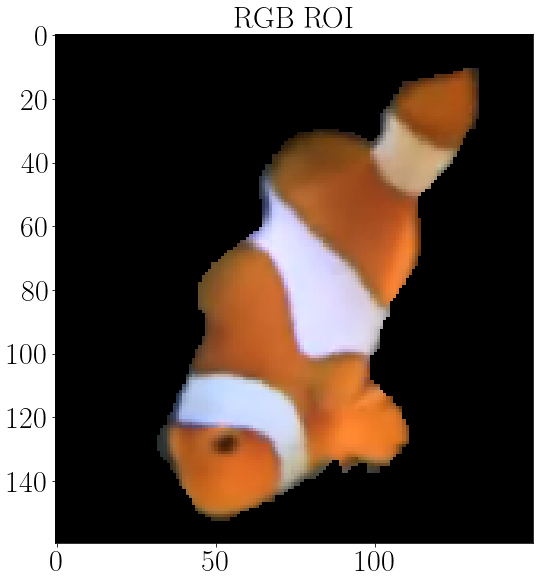

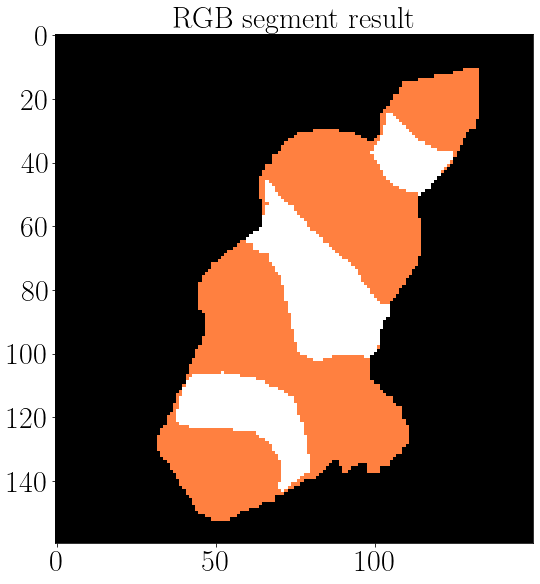

In [21]:
# 三维时，贝叶斯
# ------------------------------------------------------------------------------------#
# 数据为三维时(彩色图像)，用最大似然估计两个类别条件概率pdf的参数——协方差与均值
# means
RGB1_m = np.mean(RGB1, axis=0)
RGB2_m = np.mean(RGB2, axis=0)



cov_sum1 = np.zeros((3, 3))
cov_sum2 = np.zeros((3, 3))

for i in range(len(RGB1)):
    # print((RGB1[i]-RGB1_m).reshape(3, 1))
    cov_sum1 = cov_sum1 + np.dot((RGB1[i]-RGB1_m).reshape(3, 1), (RGB1[i]-RGB1_m).reshape(1, 3))

for i in range(len(RGB2)):
    cov_sum2 = cov_sum2 + np.dot((RGB2[i]-RGB2_m).reshape(3, 1), (RGB2[i]-RGB2_m).reshape(1, 3))

RGB1_cov = cov_sum1/(len(RGB1)-1)                      # 无偏估计除以N-1
RGB2_cov = cov_sum2/(len(RGB2)-1)

xx = np.array([x, x, x])
# print(P_pre1*multivariate_normal.pdf(RGB1, RGB1_m, RGB1_cov))

# 用最大后验贝叶斯对彩色图像进行分割
RGB_out = np.zeros_like(RGB_ROI)
for i in range(len(RGB_ROI)):
    for j in range(len(RGB_ROI[0])):
        if np.sum(RGB_ROI[i][j]) == 0:
            continue
        elif P_pre1*multivariate_normal.pdf(RGB_ROI[i][j], RGB1_m, RGB1_cov) > P_pre2*multivariate_normal.pdf(RGB_ROI[i][j], RGB2_m, RGB2_cov): # 贝叶斯公式分子比较
            RGB_out[i][j] = np.array([255, 128, 64]) / 255
        else:
            RGB_out[i][j] = np.array([255, 255, 255]) / 255
# print(RGB_ROI.shape)

# 显示RGB ROI，与彩色分割结果
plt.figure(3)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx = plt.subplot(1, 1, 1)
cx.set_title('RGB ROI',fontsize = 30)
cx.imshow(RGB_ROI)
plt.figure(4)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx1 = plt.subplot(1, 1, 1)
cx1.set_title('RGB segment result',fontsize = 30)
cx1.imshow(RGB_out)
plt.show()

## K-means

W:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
W:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

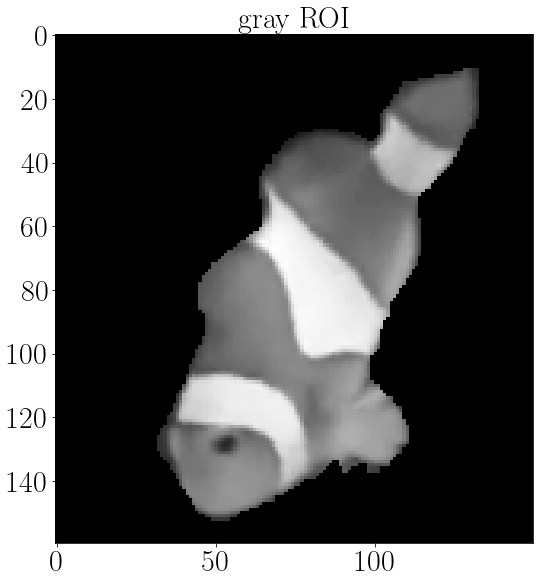

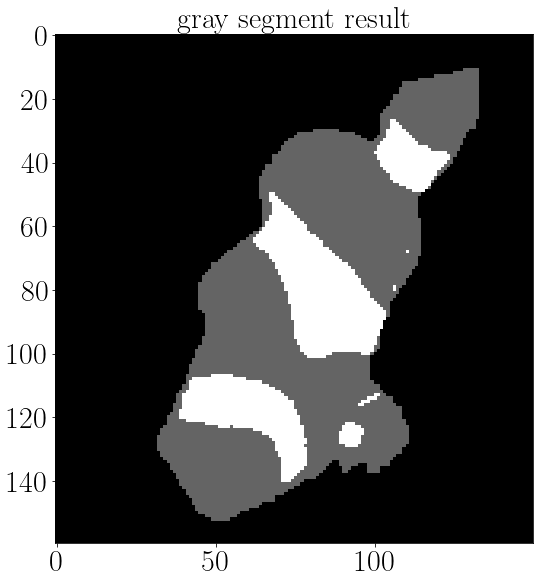

In [22]:

km=KMeans(n_clusters=2)
#聚类获得每个像素所属的类别
label =km.fit_predict(Gray_ROI_sample.reshape(-1, 1))

gray_out = np.zeros_like(Gray_ROI)
flag = 0
for i in range(len(Gray_ROI)):
    for j in range(len(Gray_ROI[0])):
        if np.sum(RGB_ROI[i][j]) == 0:
            continue
        elif not label[flag]:
            gray_out[i][j] = 100
            flag -=-1
        else:
            gray_out[i][j] = 255
            flag -=-1
# plt.imshow(RGB_ROI)
plt.figure(2)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
bx = plt.subplot(1, 1, 1)
bx.set_title('gray ROI',fontsize = 30)
bx.imshow(Gray_ROI, cmap='gray')
plt.figure(3)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
bx1 = plt.subplot(1, 1, 1)
bx1.set_title('gray segment result',fontsize = 30)
bx1.imshow(gray_out, cmap='gray')

W:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
W:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

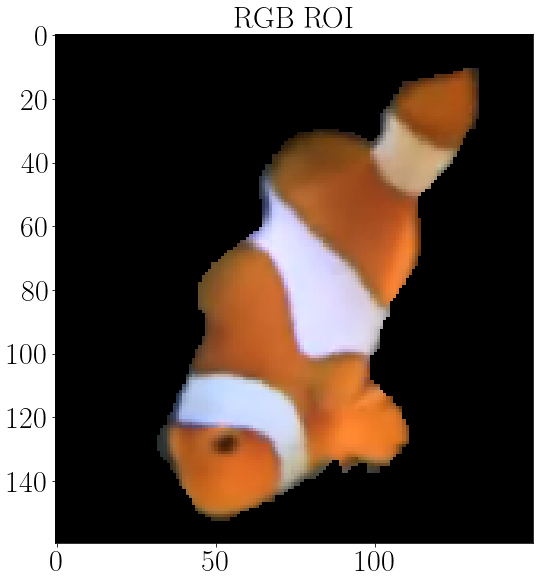

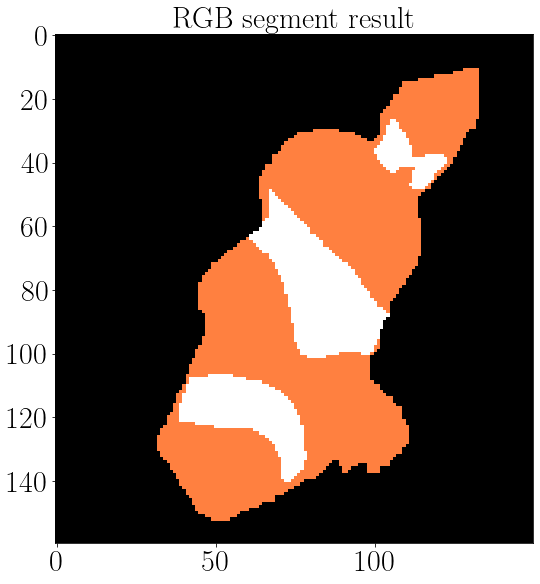

In [27]:
km=KMeans(n_clusters=2)
#聚类获得每个像素所属的类别
label =km.fit_predict(RGB_ROI_sample)
flag = 0
RGB_out = np.zeros_like(RGB_ROI)
for i in range(len(RGB_ROI)):
    for j in range(len(RGB_ROI[0])):
        if np.sum(RGB_ROI[i][j]) == 0:
            continue
        elif not label[flag]:
            RGB_out[i][j] = np.array([255, 128, 64]) / 255
            flag -=-1
        else:
            RGB_out[i][j] = np.array([255, 255, 255]) / 255
            flag -=-1
            
plt.figure(3)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx = plt.subplot(1, 1, 1)
cx.set_title('RGB ROI',fontsize = 30)
cx.imshow(RGB_ROI)
plt.figure(4)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx1 = plt.subplot(1, 1, 1)
cx1.set_title('RGB segment result',fontsize = 30)
cx1.imshow(RGB_out)
plt.show()

W:\Anaconda\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
W:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

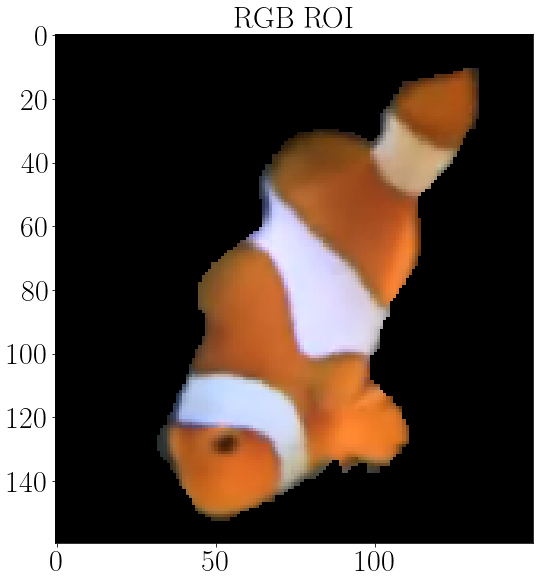

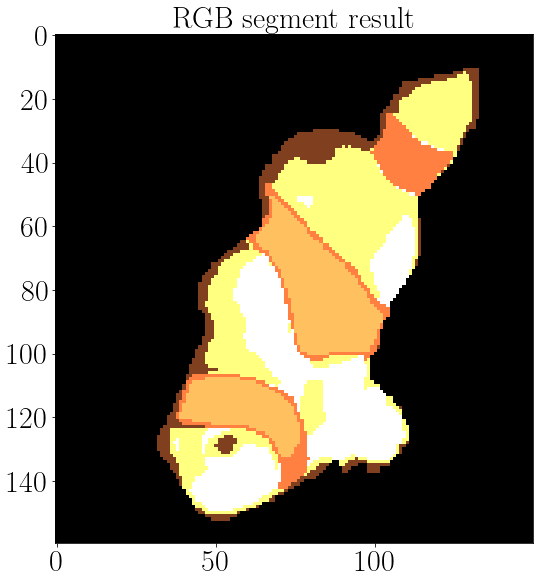

In [38]:
km=KMeans(n_clusters=5)
#聚类获得每个像素所属的类别
label =km.fit_predict(RGB_ROI_sample)
flag = 0
RGB_out = np.zeros_like(RGB_ROI)
for i in range(len(RGB_ROI)):
    for j in range(len(RGB_ROI[0])):
        if np.sum(RGB_ROI[i][j]) == 0:
            continue
        elif label[flag] == 4 :
            RGB_out[i][j] = np.array([255, 255, 255]) / 255
            flag -=-1
        elif label[flag] == 3:
            RGB_out[i][j] = np.array([128, 64, 32]) / 255
            flag -=-1
        elif label[flag] == 2 :
            RGB_out[i][j] = np.array([128, 64, 32]) / 255*2
            flag -=-1
        elif label[flag] == 1:
            RGB_out[i][j] = np.array([128, 64, 32]) / 255*3
            flag -=-1
        else:
            RGB_out[i][j] = np.array([128, 64, 32]) / 255*4
            flag -=-1
            
plt.figure(3)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx = plt.subplot(1, 1, 1)
cx.set_title('RGB ROI',fontsize = 30)
cx.imshow(RGB_ROI)
plt.figure(4)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx1 = plt.subplot(1, 1, 1)
cx1.set_title('RGB segment result',fontsize = 30)
cx1.imshow(RGB_out)
plt.show()

W:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
W:\Anaconda\lib\site-packages\ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

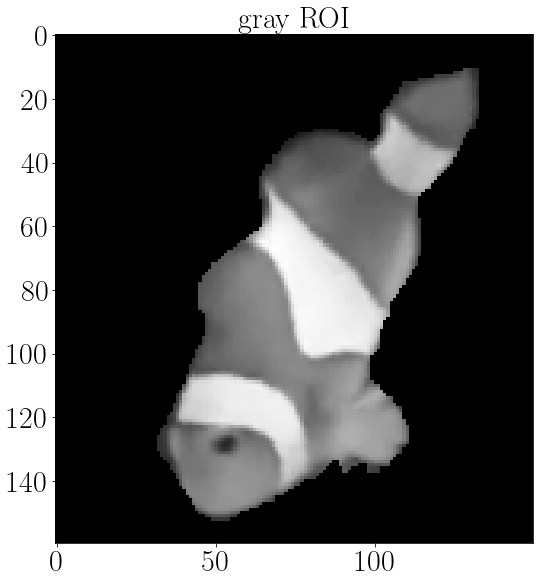

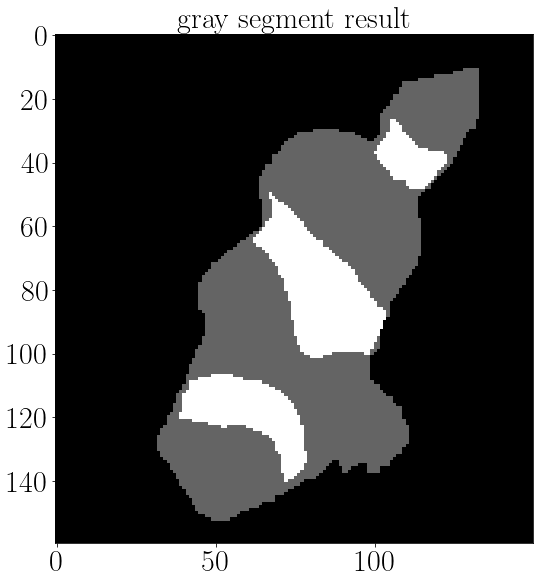

In [39]:
km=KMeans(n_clusters=2)
#聚类获得每个像素所属的类别
label =km.fit_predict(Gray_ROI_sample.reshape(-1, 1))
gray1, gray2 = [], []
P_pre1, P_pre2 =0, 0
for i,data in enumerate(label):
    if not data:
        gray1.append(Gray_ROI_sample[i])
        P_pre1 -=- 1
    else:
        gray2.append(Gray_ROI_sample[i])
        P_pre2 -=- 1
P_pre1 = P_pre1 / len(Gray_ROI_sample)
P_pre2 = P_pre2 / len(Gray_ROI_sample)

gray1_m = np.mean(gray1)
gray1_s = np.std(gray1)
gray2_m = np.mean(gray2)
gray2_s = np.std(gray2)

x = np.arange(0, 1, 1/1000)
gray1_pdf = norm.pdf(x, gray1_m, gray1_s)
gray2_pdf = norm.pdf(x, gray2_m, gray2_s)
# 用最大后验贝叶斯对灰度图像进行分割
gray_out = np.zeros_like(Gray_ROI)
for i in range(len(Gray_ROI)):
    for j in range(len(Gray_ROI[0])):
        if Gray_ROI[i][j] == 0:
            continue
        elif P_pre1*norm.pdf(Gray_ROI[i][j], gray1_m, gray1_s) > P_pre2*norm.pdf(Gray_ROI[i][j], gray2_m, gray2_s):   # 贝叶斯公式分子比较
            gray_out[i][j] = 100
        else:
            gray_out[i][j] = 255

# plt.imshow(RGB_ROI)
plt.figure(2)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
bx = plt.subplot(1, 1, 1)
bx.set_title('gray ROI',fontsize = 30)
bx.imshow(Gray_ROI, cmap='gray')
plt.figure(3)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
bx1 = plt.subplot(1, 1, 1)
bx1.set_title('gray segment result',fontsize = 30)
bx1.imshow(gray_out, cmap='gray')

Text(0, 0.5, '$f(x)$')

<Figure size 432x288 with 0 Axes>

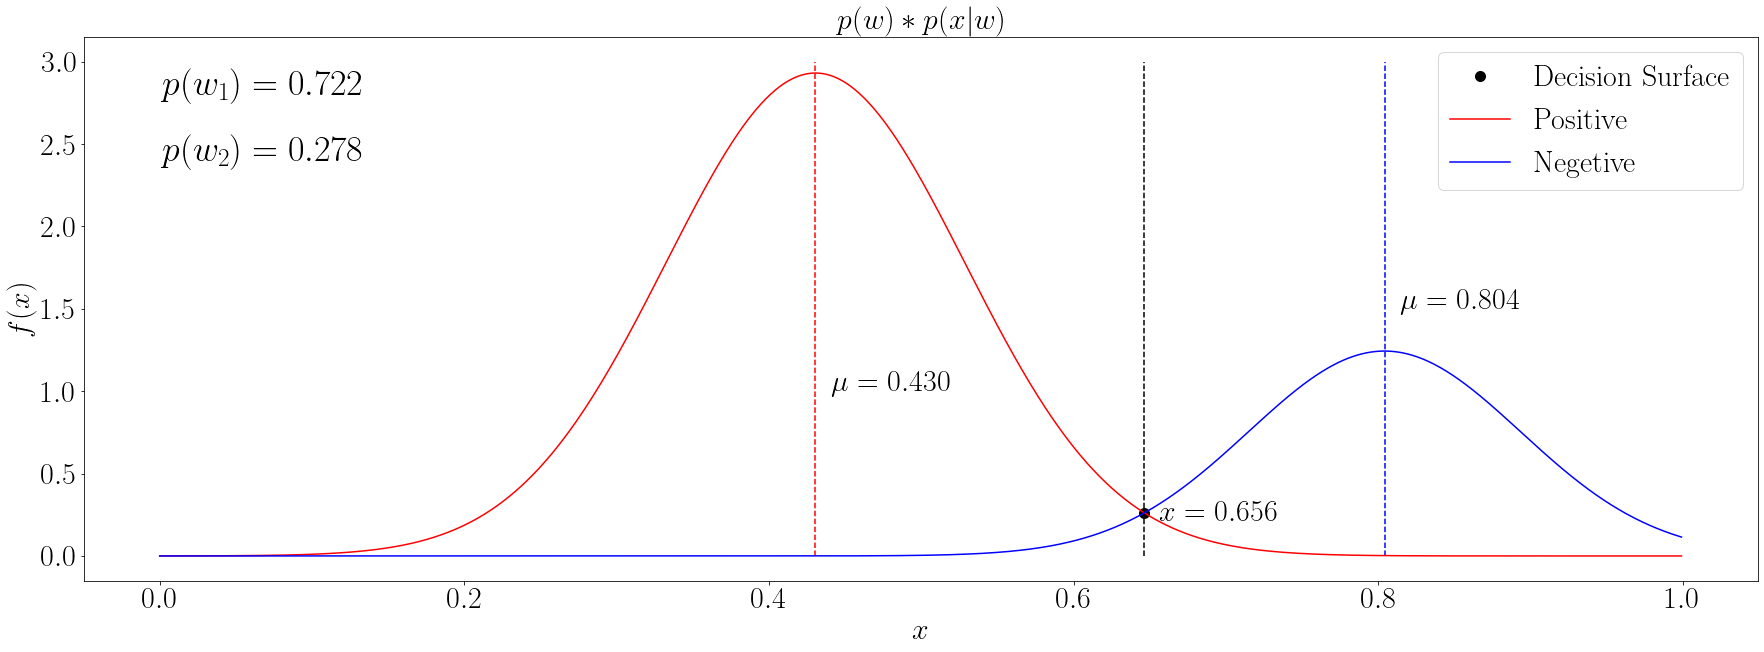

In [31]:
plt.figure(1)
plt.figure(figsize=(30, 10))
ax3 = plt.subplot(1, 1, 1)
ax3.set_title('$p(w)*p(x|w)$', fontsize=30)

gray_dist = np.abs(P_pre1*gray1_pdf[200:] - P_pre2*gray2_pdf[200:])
gray_face = np.min(gray_dist)
gray_face_loc = np.where(gray_dist == gray_face)
gray_face_loc = gray_face_loc[0] + 200
ax3.plot(gray_face_loc/1000, P_pre1*gray1_pdf[gray_face_loc], 'ko', markersize=10,label = 'Decision Surface')

plt.vlines(gray_face_loc/1000, 0, 3, colors = "k", linestyles = "dashed")
plt.text(gray_face_loc/1000 + 0.01 ,P_pre1*gray1_pdf[gray_face_loc]-0.05,'$x=%.3f$'%(gray_face_loc/1000 + 0.01), fontsize=30)

plt.vlines(gray1_m, 0, 3, colors = "r", linestyles = "dashed")
plt.text(gray1_m + 0.01,1,'$\mu=%.3f$'%gray1_m, fontsize=30)
plt.vlines(gray2_m, 0, 3, colors = "b", linestyles = "dashed")
plt.text(gray2_m + 0.01,1.5,'$\mu=%.3f$'%gray2_m, fontsize=30)
plt.text(0,2.8,'$p(w_1)=%.3f$'%P_pre1, fontsize=36)
plt.text(0,2.4,'$p(w_2)=%.3f$'%P_pre2, fontsize=36)
ax3.plot(x, P_pre1*gray1_pdf, 'r', label = 'Positive')
ax3.plot(x, P_pre2*gray2_pdf, 'b', label = 'Negetive')
plt.legend(fontsize=30)

plt.tick_params(labelsize=30)
ax3.set_xlabel('$x$', fontsize=30)
ax3.set_ylabel('$f(x)$', fontsize=30)

W:\Anaconda\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
W:\Anaconda\lib\site-packages\ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

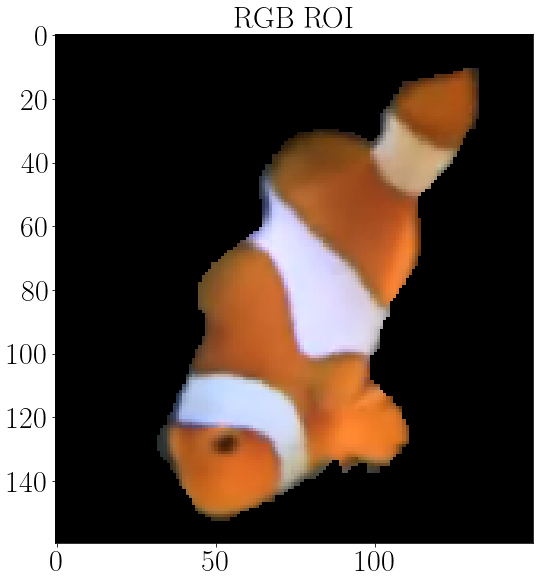

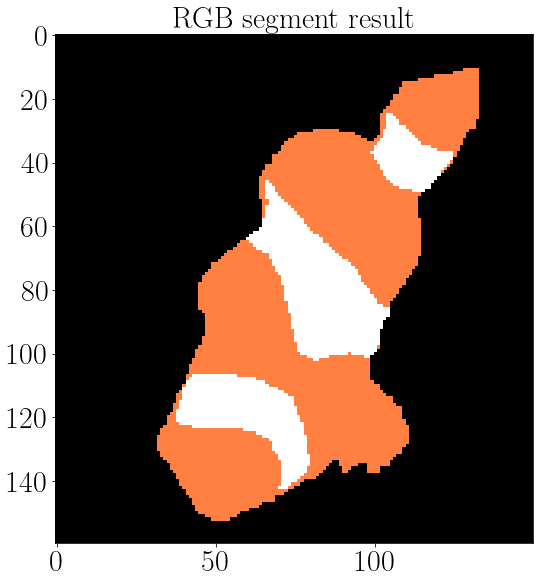

In [41]:
km=KMeans(n_clusters=2)
#聚类获得每个像素所属的类别
label =km.fit_predict(RGB_ROI_sample)
RGB_1, RGB_2 = [], []
P_pre1, P_pre2 =0, 0
for i,data in enumerate(label):
    if data <= 0:
        RGB_1.append(RGB_ROI_sample[i])
        P_pre1 -=- 1
    else:
        RGB_2.append(RGB_ROI_sample[i])
        P_pre2 -=- 1
P_pre1 = P_pre1 / len(Gray_ROI_sample)
P_pre2 = P_pre2 / len(Gray_ROI_sample)  
# 三维时，贝叶斯
# ------------------------------------------------------------------------------------#
# 数据为三维时(彩色图像)，用最大似然估计两个类别条件概率pdf的参数——协方差与均值
# means
RGB1_m = np.mean(RGB1, axis=0)
RGB2_m = np.mean(RGB2, axis=0)



cov_sum1 = np.zeros((3, 3))
cov_sum2 = np.zeros((3, 3))

for i in range(len(RGB1)):
    # print((RGB1[i]-RGB1_m).reshape(3, 1))
    cov_sum1 = cov_sum1 + np.dot((RGB1[i]-RGB1_m).reshape(3, 1), (RGB1[i]-RGB1_m).reshape(1, 3))

for i in range(len(RGB2)):
    cov_sum2 = cov_sum2 + np.dot((RGB2[i]-RGB2_m).reshape(3, 1), (RGB2[i]-RGB2_m).reshape(1, 3))

RGB1_cov = cov_sum1/(len(RGB1)-1)                      # 无偏估计除以N-1
RGB2_cov = cov_sum2/(len(RGB2)-1)

xx = np.array([x, x, x])
# print(P_pre1*multivariate_normal.pdf(RGB1, RGB1_m, RGB1_cov))

# 用最大后验贝叶斯对彩色图像进行分割
RGB_out = np.zeros_like(RGB_ROI)
for i in range(len(RGB_ROI)):
    for j in range(len(RGB_ROI[0])):
        if np.sum(RGB_ROI[i][j]) == 0:
            continue
        elif P_pre1*multivariate_normal.pdf(RGB_ROI[i][j], RGB1_m, RGB1_cov) > P_pre2*multivariate_normal.pdf(RGB_ROI[i][j], RGB2_m, RGB2_cov): # 贝叶斯公式分子比较
            RGB_out[i][j] = np.array([255, 128, 64]) / 255
        else:
            RGB_out[i][j] = np.array([255, 255, 255]) / 255
# print(RGB_ROI.shape)

# 显示RGB ROI，与彩色分割结果
plt.figure(3)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx = plt.subplot(1, 1, 1)
cx.set_title('RGB ROI',fontsize = 30)
cx.imshow(RGB_ROI)
plt.figure(4)
plt.figure(figsize=(10, 37.5/4))
plt.tick_params(labelsize=30)
cx1 = plt.subplot(1, 1, 1)
cx1.set_title('RGB segment result',fontsize = 30)
cx1.imshow(RGB_out)
plt.show()